# "SpreadSheet Munging Strategies in Python - Meaningful Formats"
> "Extract data from spreadsheets with formats"

- toc: true
- branch: master
- badges: true
- hide_binder_badge: True
- hide_colab_badge: True
- comments: true
- categories: [Spreadsheet, Python, Pandas]
- image: images/some_folder/your_image.png
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

## __Meaningful Formats__

This is part of a series of blog posts about extracting data from spreadsheets using Python.  It is based on the [book](https://nacnudus.github.io/spreadsheet-munging-strategies/index.html) written by [Duncan Garmonsway](https://twitter.com/nacnudus?lang=en), which was written primarily for R users. LInks to the other posts are on the [homepage](https://samukweku.github.io/data-wrangling-blog/).

This is an excerpt from [Duncan's book](https://nacnudus.github.io/spreadsheet-munging-strategies/tidy-formatted-rows.html) regarding meaningful formats :
>Sometimes whole rows in a table are highlighted by formatting them with, say, a bright yellow fill. The highlighting could mean “this observation should be ignored”, or “this product is no longer available”. Different colours could mean different levels of a hierarchy, e.g. green for “pass” and red for “fail”.

The examples below highlight various ways of dealing with meaningfully formatted spreadsheets. Let's dive in.

**Update**
- 2020-08-12: Code has been improved. Unnecessary steps are chunked out.

### **Case 1 : Meaningfully Formatted Rows**
![meaningfully_formatted_rows.png](Images/meaningfully_formatted_rows.png)
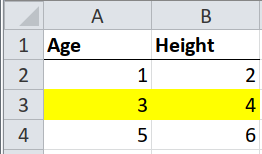

Goal is to capture the color as part of our final output. We'll use [Openpyxl](https://openpyxl.readthedocs.io/en/stable/index.html) to get the colour details.

In [1]:
import pandas as pd
import janitor
import numpy as np
from openpyxl import load_workbook  
from collections import defaultdict

filename = "Data_files/worked-examples.xlsx"

In [2]:
# read in excel file
wb = load_workbook(filename)

# access specific worksheet
ws = wb["highlights"]

Next we iterate through each column and collect similar items. Specifically, we need to get the values and the colours : 

In [3]:
from collections import defaultdict
data = defaultdict(list)

for column in ws.columns:
    for cell in column:
        data[f"{cell.column_letter}_value"].append(cell.value)
        data[f"{cell.column_letter}_colour"].append(cell.fill.fgColor.rgb)

In [4]:
data

defaultdict(list,
            {'A_value': ['Age', 1, 3, 5],
             'A_colour': ['00000000', '00000000', 'FFFFFF00', '00000000'],
             'B_value': ['Height', 2, 4, 6],
             'B_colour': ['00000000', '00000000', 'FFFFFF00', '00000000']})

Let's view the data in a dataframe :

In [5]:
df = pd.DataFrame(data)
df

,A_value,A_colour,B_value,B_colour
0,Age,00000000,Height,00000000
1,1,00000000,2,00000000
2,3,FFFFFF00,4,FFFFFF00
3,5,00000000,6,00000000


This looks better and easier to wrangle. Let's put into tidy form

In [6]:
df = (df
      # We chunk the last column, since it is the same as A_colour
      # remember, we are working with row colours
      .iloc[:, :-1]
      # cleanup here to put a relevant name 
      # since at some point we will use this row as our column headers
      .assign(A_colour = lambda x: np.where(x.index==0, 
                                            "Fill_colour", 
                                            x.A_colour))
      # row_to_names function is from the pyjanitor package
      # we promote the first row as the new column header
      .row_to_names(row_number = 0, remove_row = True)
     )

df

,Age,Fill_colour,Height
1,1,00000000,2
2,3,FFFFFF00,4
3,5,00000000,6


### **Case 2 : Meaningfully Formatted Cells**
![meaningfully_formatted_cells.png](Images/meaningfully_formatted_cells.png)
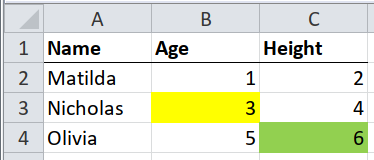

In the pic above, the table has different colors for different cells. Openpyxl comes in handy again, and the focus here, just as in Case 1, is the cell's fill attribute.

A strategy change is needed here, however. We need to identify cells that are numbers and get the cell colours, while ignoring the cell colours for text cells and the headers.

In [7]:
# openpyxl is already loaded
wb = load_workbook(filename)
ws = wb["annotations"]

data = defaultdict(list)

for row in ws.rows:
    for cell in row:
        if cell.data_type == "s":
            val = cell.value
        #attach color information to the numbers
        #color applies only to the numbers
        elif cell.data_type == "n":
            val = ','.join((str(cell.value), cell.fill.fgColor.rgb))
        data[f"column_{cell.row}"].append(val)

In [8]:
df = pd.DataFrame(data).set_index("column_1")
df

,column_2,column_3,column_4
column_1,,,
Name,Matilda,Nicholas,Olivia
Age,"1,00000000","3,FFFFFF00","5,00000000"
Height,"2,00000000","4,00000000","6,FF92D050"


In [9]:
#final cleanup
df = (df
      .row_to_names(0, True)
      .stack()
      .rename_axis(index=['Variable', "Student"])
      .str.split(",", expand = True)
      .set_axis(['value', 'fill_colour'], axis = 'columns')
       #for better view
       #put the student column before the Variable column
      .swaplevel(1,0, axis = 'index')
      .sort_index(level = 'Student')
      )

df

value fill_colour
Student  Variable                  
Matilda  Age          1    00000000
         Height       2    00000000
Nicholas Age          3    FFFFFF00
         Height       4    00000000
Olivia   Age          5    00000000
         Height       6    FF92D050

###  **Case 3 : Layered Meaningful Formatting**
![layered_meaningful_formatting.png](Images/layered_meaningful_formatting.png)
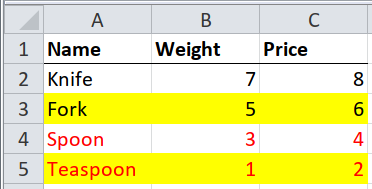

In this case, we have formats for fill and font. <br>The format applies to the entire row.

In [10]:
wb = load_workbook(filename)
ws = wb["combined-highlights"]

data = defaultdict(list)

for column in ws.columns:

    for cell in column:
        #for cells that dont have a font color attribute
        if cell.font.color is None:
            fontcolor = "FF000000"
        #cell headers(in bold format) - we don't need the colour details
        #also since the cells in the same row share the same font or fill,
        #we'll keep just the colour details for the cells that are of string type
        if cell.font.b or cell.data_type == "n" :
            val = cell.value
        else : 
            fontcolor = cell.font.color.rgb  
            val = ','.join((str(cell.value), cell.fill.fgColor.rgb, fontcolor))
        data[cell.column].append(val)            
            

In [11]:
data

defaultdict(list,
            {1: ['Name',
              'Knife,00000000,FF000000',
              'Fork,FFFFFF00,FF000000',
              'Spoon,00000000,FFFF0000',
              'Teaspoon,FFFFFF00,FFFF0000'],
             2: ['Weight', 7, 5, 3, 1],
             3: ['Price', 8, 6, 4, 2]})

In [12]:
df = pd.DataFrame(data)
df

,1,2,3
0,Name,Weight,Price
1,"Knife,00000000,FF000000",7,8
2,"Fork,FFFFFF00,FF000000",5,6
3,"Spoon,00000000,FFFF0000",3,4
4,"Teaspoon,FFFFFF00,FFFF0000",1,2


In [13]:
df = (df.row_to_names(0, True) 
       .set_index(['Weight', 'Price'])
       .Name.str.split(',', expand = True)
       .set_axis(['Name', 'fill_colour', 'font_colour'],axis = 'columns')
       .reset_index()
      )

df

,Weight,Price,Name,fill_colour,font_colour
0,7,8,Knife,00000000,FF000000
1,5,6,Fork,FFFFFF00,FF000000
2,3,4,Spoon,00000000,FFFF0000
3,1,2,Teaspoon,FFFFFF00,FFFF0000


###  **Case 4 : Hierarchies in Formatting**
![hierarchies_in_formatting.png](Images/hierarchies_in_formatting.png)
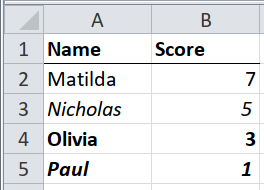

In the pic above, notice the differences in the formatting (bold, italic, bold and italic, none). In Duncan's book, he offers a suggestion on what these different levels of hierarchy might mean : <br>
- none - good
- italic - satisfactory
- bold - poor
- bold and italic - fail
<br><br>
Again, the formatting is applied to the entire row.

In [14]:
wb = load_workbook(filename)
ws = wb["highlight-hierarchy"]

data = defaultdict(list)

for column in ws.columns:
    for cell in column:
        data[f"{cell.column_letter}_value"].append(cell.value)
        data[f"{cell.column_letter}_bold"].append(cell.font.b)
        data[f"{cell.column_letter}_italics"].append(cell.font.i)

In [15]:
data

defaultdict(list,
            {'A_value': ['Name', 'Matilda', 'Nicholas', 'Olivia', 'Paul'],
             'A_bold': [True, False, False, True, True],
             'A_italics': [False, False, True, False, True],
             'B_value': ['Score', 7, 5, 3, 1],
             'B_bold': [True, False, False, True, True],
             'B_italics': [False, False, True, False, True]})

In [16]:
#create dataframe
df = pd.DataFrame(data)
df

,A_value,A_bold,A_italics,B_value,B_bold,B_italics
0,Name,True,False,Score,True,False
1,Matilda,False,False,7,False,False
2,Nicholas,False,True,5,False,True
3,Olivia,True,False,3,True,False
4,Paul,True,True,1,True,True


In [17]:
df = (pd.DataFrame(data)
      .loc[:, "A_value" : "B_value"]
      .assign(A_bold = lambda x: np.where(x.A_value == "Name", "Bold", x.A_bold),
              A_italics = lambda x: np.where(x.A_value == "Name", "Italics", x.A_italics)
             )
      .row_to_names(row_number = 0, remove_row = True)
     )

df

,Name,Bold,Italics,Score
1,Matilda,False,False,7
2,Nicholas,False,True,5
3,Olivia,True,False,3
4,Paul,True,True,1


In [18]:
#last part is to create a grade column based on the bold and italics columns :
#create a mapping
mapping = {'False,False':'good',
        'False,True':'satisfactory',
        'True,False':'poor',
        'True,True':'fail'}

df['grade'] = df.Bold.str.cat(df.Italics, sep=",").map(mapping)

df

,Name,Bold,Italics,Score,grade
1,Matilda,False,False,7,good
2,Nicholas,False,True,5,satisfactory
3,Olivia,True,False,3,poor
4,Paul,True,True,1,fail
